## Author : Loka Akash Reddy
### Innomatics Research Labs - Data Science October - 2021
### Tasks - Machine Learning
### Task 2 - Classification Algorithm
### Classification on CIFAR 10 Dataset
###  Kindly follow the instructions given in this document : https://docs.google.com/document/d/1598tSMcK-WvxrJdBC7GmJ0wrlFAxRxw4ifTo1z4AETE/edit?usp=sharing
### Kindly checkout the jupyter notebook for more details: https://drive.google.com/file/d/1FSXSAWKOKcibqiRBmcWuXNMslaTv2dxn/view
### Importing required libraries
### Step - 1 (Setup Code)

### Data Description:
CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 data consists of 60,000 32x32 color images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images in the official data. We have preserved the train/test split from the original dataset.  The provided files are:

train.7z - a folder containing the training images in png format

test.7z - a folder containing the test images in png format

trainLabels.csv - the training labels

To discourage certain forms of cheating (such as hand labeling) we have added 290,000 junk images in the test set. These images are ignored in the scoring. We have also made trivial modifications to the official 10,000 test images to prevent looking them up by file hash. These modifications should not appreciably affect the scoring. You should predict labels for all 300,000 images.

The label classes in the dataset are:

- airplane 
- automobile 
- bird 
- cat 
- deer 
- dog 
- frog 
- horse 
- ship 
- truck

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

In [1]:
from __future__ import print_function
from builtins import range
from six.moves import cPickle as pickle
from imageio import imread

import random
import numpy as np
import matplotlib.pyplot as plt
import os


import platform

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Step - 2 (Download the dataset)

In [3]:
### Use this code to download the dataset for the first time
### You will be required to install wget using pip
### For Linux users checkout the alternative for 'del'

!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!del cifar-10-python.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'cifar-10-python.tar.gz'
Could Not Find C:\Users\akash\Documents\Intern\Innomatics Research Labs\Tasks\Machine Learning\Task 2 - Classification Algorithm\cifar-10-python.tar.gz


### Step - 3 (Load the Dataset)

In [4]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Step - 4 (Visualization)
Next we visualize the CIFAR-10 dataset. Although these functions are being written for you, we highly recommend you go through the code and make yourself familiar as these are things you will be required to do very often when working on AI/ML projects

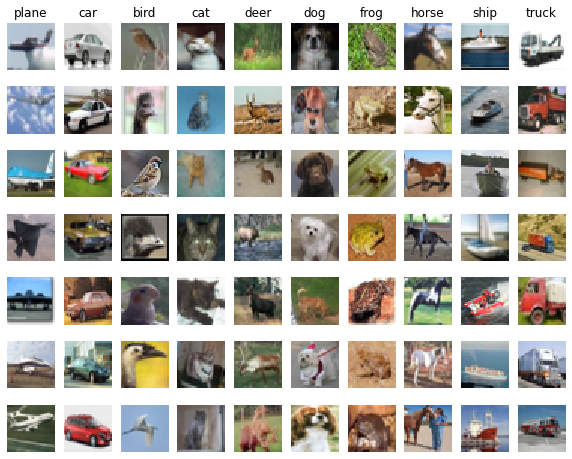

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Step - 5 (Flattening the images)
In the next cell we flatten each image into a single dimensional vector so that it is easy to process. You should be able to reason about the dimensions comfortable.

In [6]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


### Step - 6 (Apply all possible classification algorithms)
For each algo complete the following steps with appropriate plots, diagrams and code -

1. Discuss the intuition behind each algorithm
2. Mention pros and cons
3. Discuss about Model parameters and Hyperparameters
4. Discuss about overfitting and underfitting with relavant plots and code (Hint: Use cross validation and plot hyperparameter vs accuracy score)
5. Discuss about train and test time/space complexities
6. Measure the performance of model using various metrics and write in detail about each metric

### Step - 7 (Compare all the models)
Conclude by following below mentioed steps -

1. Plot a table showing all the algorithms used and corresponding performance metrics
2. Is there any one algorithm that can be used on all the datasets? (Hint: Read about 'No Free Lunch' theorem)

## Thank you